In [15]:
import csv
import sys
import os
import pickle
import random
import numpy as np
import time
import operator
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

import statsmodels.stats.api as sms

import scipy.stats
from scipy.stats import entropy
from scipy.stats import spearmanr
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
np.set_printoptions(precision=2)

In [17]:
sys.path.append('../python')
from permutation import permutation, compute_alignment_strength
from utils.utils_funcs import aggregate_embeddings_visual_and_language, get_variance, get_distinctness_from_nearest_5
from utils.utils_funcs import load_data_to_dict

In [18]:
def get_alignment_strength(struct,concepts,relative):
    visual_embeddings_list=list()
    langauge_embeddings_list=list()
    for concept in concepts:
        embeddings=struct["embeds"][concept]
        visual_embeddings_list.append(embeddings["visual"])
        langauge_embeddings_list.append(embeddings["language"])
    z_0=np.array(visual_embeddings_list)
    z_1=np.array(langauge_embeddings_list)
    if relative:
        return permutation(z_0,z_1,n_sim=100)[0]
    else:
        return compute_alignment_strength(z_0,z_1)

In [19]:
vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_concept_least20_swav_bert_20.pkl","rb"))
vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_concept_least20_swav_bert_20.pkl","rb"))

aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,20,20)
aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,20,20)

In [20]:
# vg_noun_data=pickle.load(open("../data/dumped_embeddings/vg_noun_least10_bert_window51_10.pkl","rb"))
# vg_verb_data=pickle.load(open("../data/dumped_embeddings/vg_verb_least10_bert_window51_10.pkl","rb"))

# aggregated_vg_noun_data=aggregate_embeddings_visual_and_language(vg_noun_data,10,10)
# aggregated_vg_verb_data=aggregate_embeddings_visual_and_language(vg_verb_data,10,10)

In [21]:
noun_freq_dict=load_data_to_dict("../data/processed/childes_noun_freq.txt",header=True)
verb_freq_dict=load_data_to_dict("../data/processed/childes_verb_freq.txt",header=True)

In [22]:
noun_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_noun_aoa.txt",concepts=vg_noun_data["words"])
verb_aoa_dict=load_data_to_dict("../data/processed/aoa/kuperman_verb_aoa.txt",concepts=vg_verb_data["words"])

noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [23]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/wordbank_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [24]:
# noun_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_noun_aoa.txt",concepts=vg_noun_data["words"])
# verb_aoa_dict=load_data_to_dict("../data/processed/aoa/glasgow_verb_aoa.txt",concepts=vg_verb_data["words"])

# noun_aoa_sorted = sorted(noun_aoa_dict.items(), key=operator.itemgetter(1))
# verb_aoa_sorted = sorted(verb_aoa_dict.items(), key=operator.itemgetter(1))

In [25]:
cooccurence_data=pickle.load(open("../data/processed/dumped/verb_cooccurence_visual.pkl","rb"))

In [26]:
co_table=cooccurence_data["table"]
co_nouns=cooccurence_data["nouns"]
co_verbs=cooccurence_data["verbs"]

In [27]:
co_bi_table=np.zeros(co_table.shape)
for i,row in enumerate(co_table):
    for j,cell in enumerate(row):
        if cell:
            co_bi_table[i][j]=1
        else:
            co_bi_table[i][j]=0

In [28]:
heaviness_list=list()
for i in range(len(co_bi_table)):
    heaviness_list.append(np.sum(co_bi_table[i])/np.sum(co_table[i]))
# heaviness_list=np.sum(co_bi_table,axis=1)
heaviness=dict()
for i,verb in enumerate(co_verbs):
    concept=verb.split(".")[0]
    if concept in vg_verb_data["words"]:
        heaviness[concept]=heaviness_list[i]
heaviness_sorted= sorted(heaviness.items(), key=operator.itemgetter(1))

In [29]:
def get_alignment_of_subset(struct,sampled_concepts):
    v=list()
    l=list()
    for concept in sampled_concepts:
        v.append(struct["embeds"][concept]["visual"])
        l.append(struct["embeds"][concept]["language"])
    v=np.array(v)
    l=np.array(l)
    return compute_alignment_strength(v,l)

In [30]:
def get_avg(concepts,var_dict):
    var_list=list()
    for concept in concepts:
        if concept in var_dict:
            var_list.append(var_dict[concept])
    if var_list:
        return round(np.mean(var_list),4)
    else:
        return 0

In [31]:
def gen_sample(struct,aoa_dict,freq_dict,sample_size=50,n_sim=1000):
    alignment_list=list()
    aoa_list=list()
    freq_list=list()
    for i in range(n_sim):
        sys=random.sample(struct["words"],sample_size)
        alignment_list.append(get_alignment_of_subset(struct,sys))
        aoa_list.append(get_avg(sys,aoa_dict))
        freq_list.append(get_avg(sys,freq_dict))
    return alignment_list,aoa_list,freq_list

In [32]:
def gen_diff_sample(struct,aoa_dict,sample_size=50,n_sim=1000):
    diff_alignment_list=list()
    diff_aoa_list=list()
    for i in range(n_sim):
        sys1=random.sample(struct["words"],sample_size)
        sys2=random.sample(struct["words"],sample_size)
        diff_alignment=get_alignment_of_subset(struct,sys1)-get_alignment_of_subset(struct,sys2)
        diff_aoa=get_avg(sys1,aoa_dict)-get_avg(sys2,aoa_dict)
        diff_alignment_list.append(diff_alignment)
        diff_aoa_list.append(diff_aoa)
    return diff_alignment_list,diff_aoa_list

In [33]:
ags,aoas,freqs=gen_sample(aggregated_vg_noun_data,noun_aoa_dict,noun_freq_dict,sample_size=50)

slope: [-0.02]
coefficient: -0.06452359648374997


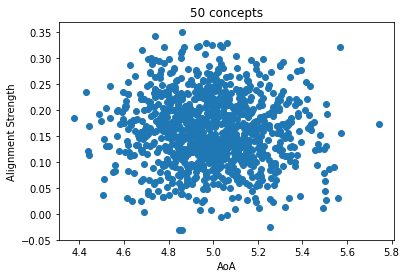

In [34]:
plt.scatter(aoas,ags)
plt.title("50 concepts")
plt.xlabel("AoA")
plt.ylabel("Alignment Strength")
reg = LinearRegression().fit([[i] for i in aoas], ags)
print("slope:",reg.coef_)
print("coefficient:",np.corrcoef(aoas,ags)[0][1])

slope: [-667.6]
coefficient: -0.3057718848722342


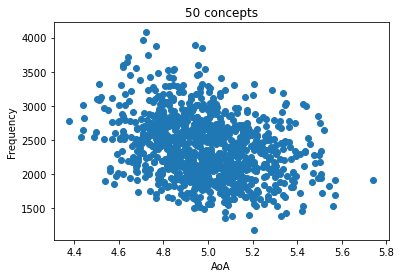

In [35]:
plt.scatter(aoas,freqs)
plt.title("50 concepts")
plt.xlabel("AoA")
plt.ylabel("Frequency")
reg = LinearRegression().fit([[i] for i in aoas], freqs)
reg.score([[i] for i in aoas], freqs)
print("slope:",reg.coef_)
print("coefficient:",np.corrcoef(aoas,freqs)[0][1])

In [39]:
ags,aoas,freqs=gen_sample(aggregated_vg_verb_data,verb_aoa_dict,verb_freq_dict,sample_size=50)

slope: [-0.03]
coefficient: -0.12783072089640152


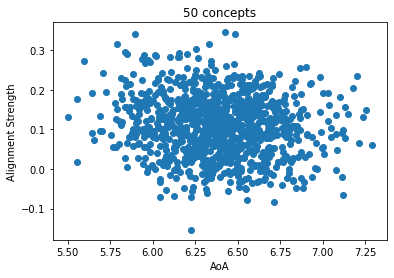

In [40]:
plt.scatter(aoas,ags)
plt.title("50 concepts")
plt.xlabel("AoA")
plt.ylabel("Alignment Strength")
reg = LinearRegression().fit([[i] for i in aoas], ags)
print("slope:",reg.coef_)
print("coefficient:",np.corrcoef(aoas,ags)[0][1])

slope: [-1353.28]
coefficient: -0.2835491049246759


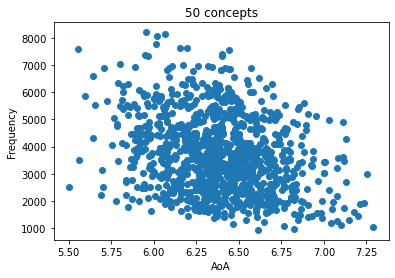

In [41]:
plt.scatter(aoas,freqs)
plt.title("50 concepts")
plt.xlabel("AoA")
plt.ylabel("Frequency")
reg = LinearRegression().fit([[i] for i in aoas], freqs)
reg.score([[i] for i in aoas], freqs)
print("slope:",reg.coef_)
print("coefficient:",np.corrcoef(aoas,freqs)[0][1])

----------

In [36]:
ags,aoas,freqs=gen_sample(aggregated_vg_noun_data,heaviness,noun_freq_dict,sample_size=50,n_sim=1000)

slope: [0.02]
coefficient: 0.048023394440334405


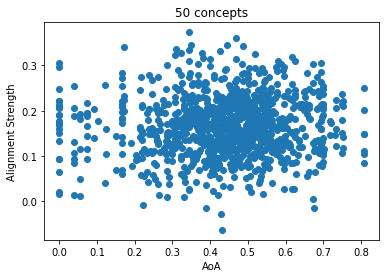

In [37]:
plt.scatter(aoas,ags)
plt.title("50 concepts")
plt.xlabel("AoA")
plt.ylabel("Alignment Strength")
reg = LinearRegression().fit([[i] for i in aoas], ags)
print("slope:",reg.coef_)
print("coefficient:",np.corrcoef(aoas,ags)[0][1])

slope: [162.98]
coefficient: 0.05650529669779556


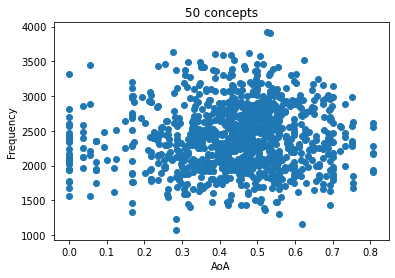

In [38]:
plt.scatter(aoas,freqs)
plt.title("50 concepts")
plt.xlabel("AoA")
plt.ylabel("Frequency")
reg = LinearRegression().fit([[i] for i in aoas], freqs)
reg.score([[i] for i in aoas], freqs)
print("slope:",reg.coef_)
print("coefficient:",np.corrcoef(aoas,freqs)[0][1])